# Использование API Fmp Cloud для отбора акций по дивидендам на Nasdaq с помощью Python
> Search for high-dividend stocks

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [finance, investment, python]

Акции с высокой дивидентной доходностью часто являются отличной инвестиционной стратегией для инвесторов, стремящихся получать приток денежных средств каждый год. В данной статье буден создан скрипт на Python для отбора их на бирже NASDAQ.

## Что такое дивидентная доходность?

Возьму определение из [Википедии](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%B2%D0%B8%D0%B4%D0%B5%D0%BD%D0%B4%D0%BD%D0%B0%D1%8F_%D0%B4%D0%BE%D1%85%D0%BE%D0%B4%D0%BD%D0%BE%D1%81%D1%82%D1%8C). **Дивиде́ндная дохо́дность** (англ. dividend yield) — это отношение величины годового дивиденда на акцию к цене акции. Данная величина выражается чаще всего в процентах.

*Пример*

При цене акции ОАО «Лукойл» 1124,37 рублей и дивиденде 28 рублей на акцию дивидендная доходность будет равна:

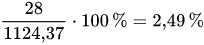


Так же необходимо обратить внимание, что многие растущие компании, такие как для примера Amazon и Yandex, не выплачивают дивиденды, поскольку они реинвестируют всю прибыль в развитие бизнеса. Поэтому дивидендная доходность для этих фирм будет равна нулю.

## Расчет дивидендной доходности с помощью Python

Расчет дивидендной доходности является простой задачей, которую можно выполнить с помощью финансового API под названием fmpcloud и Python. Этот API предлагает несколько бесплатных запросов в день после регистрации. 

1. Первым делом нужно извлечь список тикеров для всех акций, торгующихся на Nasdaq, по которым собираемся рассчитать дивидендную доходность. 

In [5]:
import requests

demo = 'Ваш API CODE'

tickers = requests.get(f'https://fmpcloud.io/api/v3/symbol/available-nasdaq?apikey={demo}')

tickers = tickers.json()
symbols = []
#for ticker in tickers:
 #   symbols.append(ticker['symbol'])

In [3]:
import requests

demo = '39b9d9eeb3ba3fe57e039284db7ed2c0'

tickers = requests.get(f'https://fmpcloud.io/api/v3/symbol/available-nasdaq?apikey={demo}')

tickers = tickers.json()
symbols = []
for ticker in tickers:
  symbols.append(ticker['symbol'])
print(symbols)
#['SMMCW', 'VOD', 'TRMD', 'TRMB', 'NBL', 'EMMA',...]

TypeError: string indices must be integers

In [2]:
len(symbols)

0

2. После необходимо пройтись по полученому списку акций и получить финансовую информацию по компании. Так же необходимо понимать, что получаем только последние данные, а не за все время существование компании.

In [ ]:
DivYield = {}
for company in symbols:
  try:
    companydata = requests.get(f'https://fmpcloud.io/api/v3/profile/{company}?apikey={demo}')
    companydata = companydata.json()
    latest_Annual_Dividend = companydata[0]['lastDiv']
    price = companydata[0]['price']
    market_Capitalization = companydata[0]['mktCap']
    name = companydata[0]['companyName']
    exchange = companydata[0]['exchange']

    dividend_Yield= latest_Annual_Dividend/price
    DivYield[company] = {}
    DivYield[company]['Dividend_Yield'] = dividend_Yield
    DivYield[company]['latest_Price'] = price
    DivYield[company]['latest_Dividend'] = latest_Annual_Dividend
    DivYield[company]['market_Capit_in_M'] = market_Capitalization/1000000
    DivYield[company]['company_Name'] = name
    DivYield[company]['exchange'] = exchange
  except:
    pass

Сбор данных может занять значительное по продолжительности время. После их можно представить в виде отсортированного DataFrame, где сверху будут акций с высокой дивидендной доходностью. 

In [ ]:
import pandas as pd
DivYield_dataframe = pd.DataFrame.from_dict(DivYield, orient='index')

DivYield_dataframe = DivYield_dataframe.sort_values(['Dividend_Yield'], ascending=[False])
DivYield_dataframe.head(15)

## Анализ полученного результата и заключение

Предварительно проведем расчет средней дивидендной доходности по акциям которые платят дивиденды:

In [ ]:
meanDivNasdaq = DivYield_dataframe[DivYield_dataframe['Dividend_Yield']>0]['Dividend_Yield'].mean()
print("Средняя дивидендная доходность по рынку Nasdaq равна ", "{:.2%}".format(meanDivNasdaq))

Самой высокой дивидендной доходностью в полученных результатах у акций компании Triumph Bancorp Inc — 21,57%. Правда по ним никогда не платили дивиденды. Так что в системе похоже сидит баг. Так же по другим рынкам заметил, что в список могут включаться акции по которым перестали платить дивиденды давно. А так, как подписка Free ограничена по количеству запросов, то подстроить ее не удалось. Так же в том случае, если при проверке выясняется, что дивиденды платили недавно, то все равно необходимо быть осторожным при выборе компаний по данному показателю, так как он может являться результатом падения цены акций и как следствия ростом дивидендной доходности. Так же выплата высоких дивидендов может не сохраниться в будущем, тем более если у компании возникнут финансовые проблемы.

Основной смысл в следующем - анализ дивидендной доходности не должен быть единственным критерием. Я для одного из своих портфелей так же смотрю: EPS, EBITDA, FCF, срок выплаты дивидендов, капитализация компании, чистая рентабельность (отношение выручки к прибыли) и коэффициент Net Debt/EBITDA.

Но как говориться - все вышеприведенное не является инвестиционной рекомендацией и выбор остается за каждым самостоятельно.